Found 8 CSV files:
 - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
 - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
 - Friday-WorkingHours-Morning.pcap_ISCX.csv
 - Monday-WorkingHours.pcap_ISCX.csv
 - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
 - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
 - Tuesday-WorkingHours.pcap_ISCX.csv
 - Wednesday-workingHours.pcap_ISCX.csv
Loaded Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv with 225745 records
Loaded Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv with 286467 records
Loaded Friday-WorkingHours-Morning.pcap_ISCX.csv with 191033 records
Loaded Monday-WorkingHours.pcap_ISCX.csv with 529918 records
Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv with 288602 records
Loaded Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv with 170366 records
Loaded Tuesday-WorkingHours.pcap_ISCX.csv with 445909 records
Loaded Wednesday-workingHours.pcap_ISCX.csv with 692703 records

Total reco

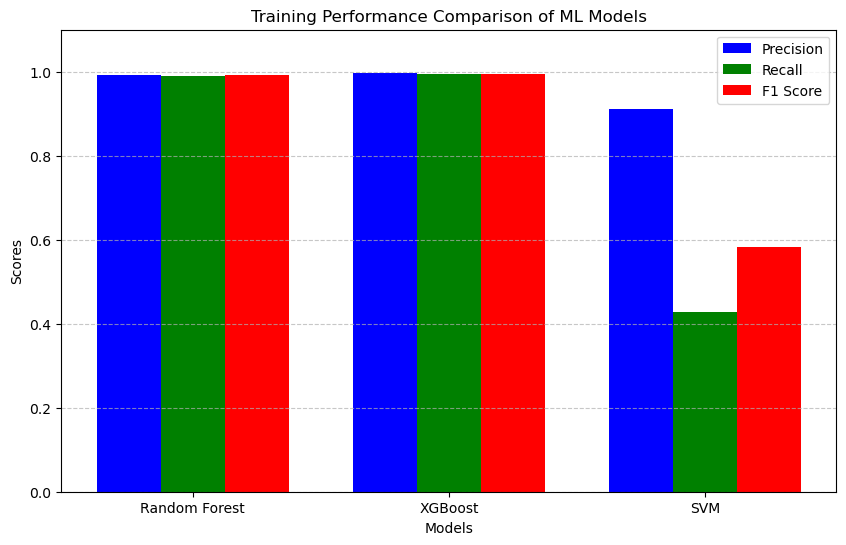

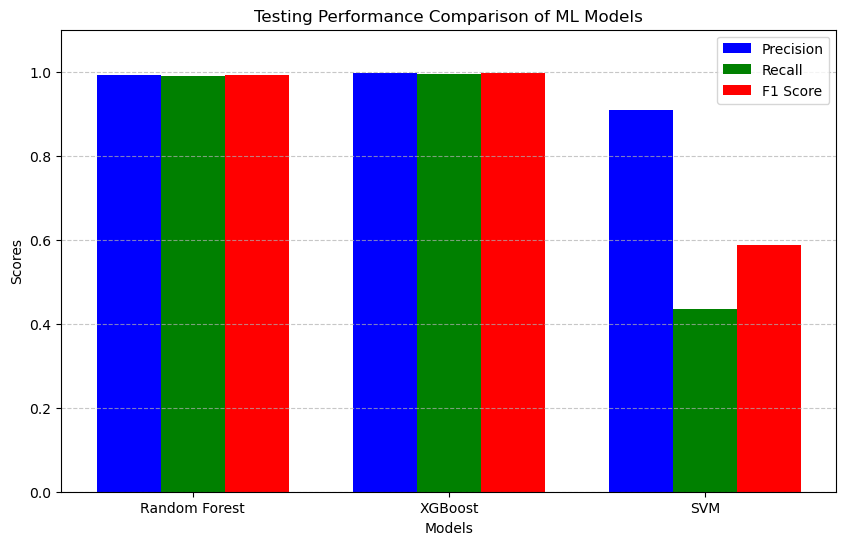

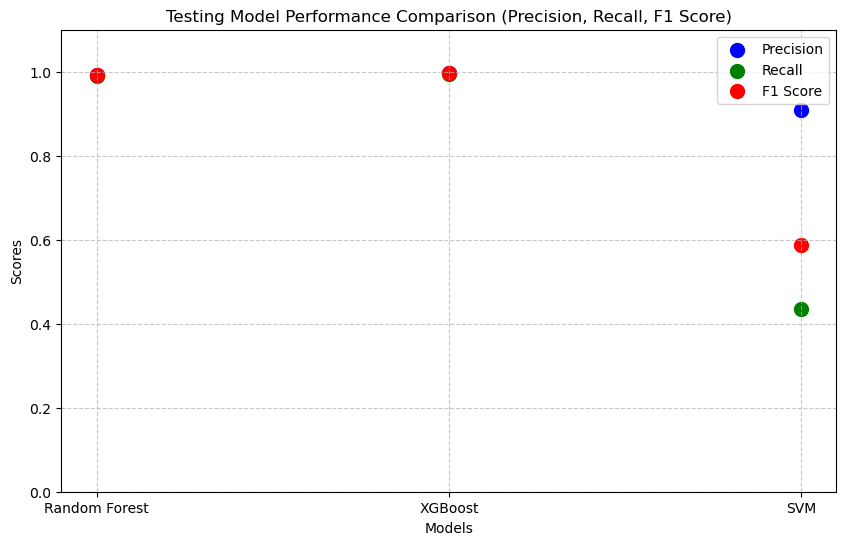

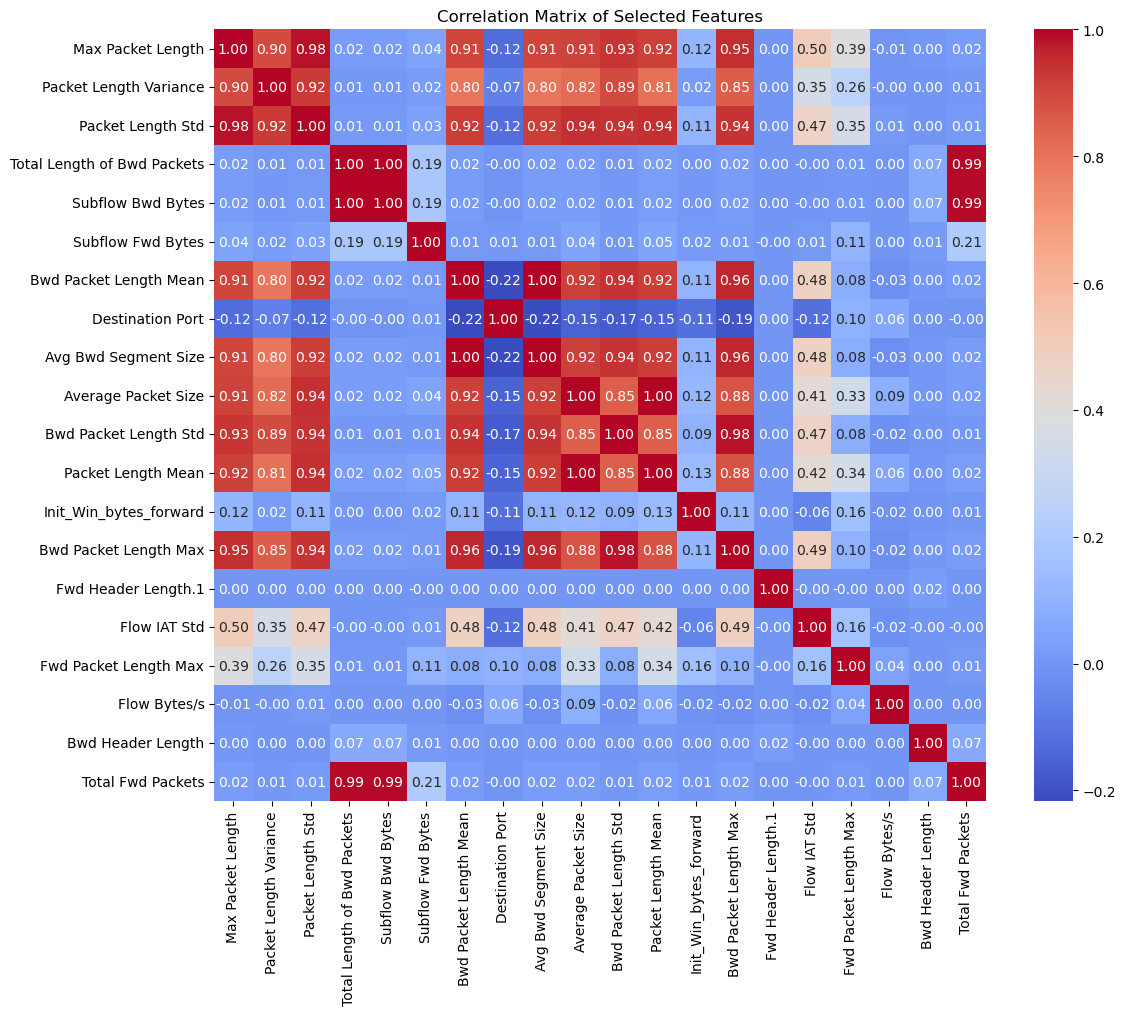

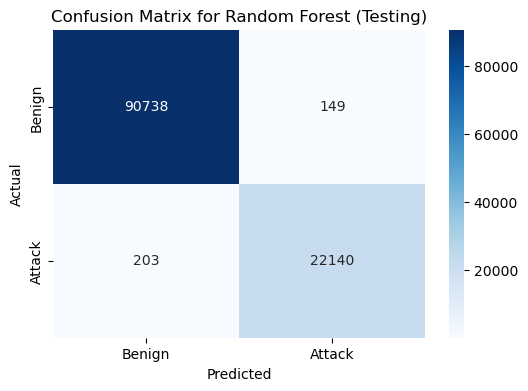

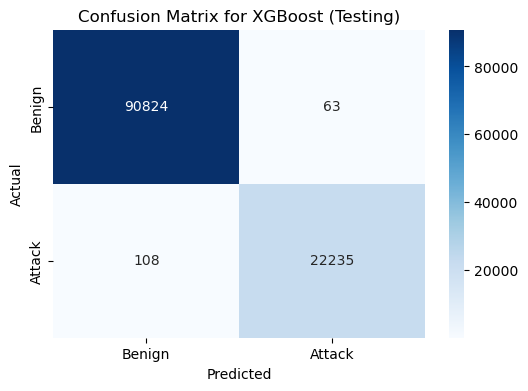

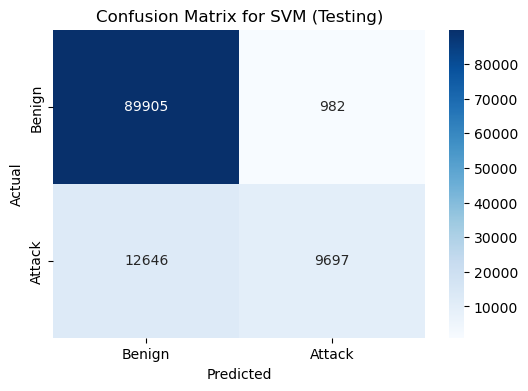

In [11]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Directory containing multiple CICIDS CSV files (update with your path)
data_dir = 'cicids_2017'

# Sampling fraction for the entire dataset (e.g., 0.2 = 20%)
sample_frac = 0.2

# Subsampling fraction for SVM training (e.g., 0.1 = 10% of sampled data)
svm_train_frac = 0.1

# Flag to enable feature selection
select_features = True
n_features_to_select = 20  # Number of top features to keep

# Function to load and combine multiple CSV files
def load_cicids_data(data_dir):
    all_files = glob.glob(os.path.join(data_dir, "*.csv"))
    if not all_files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    
    print(f"Found {len(all_files)} CSV files:")
    for f in all_files:
        print(f" - {os.path.basename(f)}")
    
    # Read and concatenate all CSV files
    df_list = []
    for file in all_files:
        try:
            df = pd.read_csv(file, low_memory=False)
            df_list.append(df)
            print(f"Loaded {os.path.basename(file)} with {len(df)} records")
        except Exception as e:
            print(f"Error loading {os.path.basename(file)}: {e}")
    
    # Combine all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"\nTotal records in combined dataset: {len(combined_df)}")
    return combined_df

# Function for feature selection using Random Forest importance
def select_top_features(X, y, n_features, feature_names):
    rf = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1][:n_features]
    selected_features = feature_names[indices]
    print(f"Selected top {n_features} features: {list(selected_features)}")
    return X[:, indices], indices

# Load the data
try:
    data = load_cicids_data(data_dir)
except FileNotFoundError as e:
    print(e)
    exit()

# Sample the dataset to reduce size
data = data.sample(frac=sample_frac, random_state=42)
print(f"Sampled dataset size: {len(data)} records")

# Preprocessing
# Remove leading/trailing spaces in column names
data.columns = data.columns.str.strip()

# Check for the label column
if 'Label' not in data.columns:
    print("Assuming last column is the label column")
    label_column = data.columns[-1]
else:
    label_column = 'Label'

# Extract features and labels
feature_names = data.drop(columns=[label_column]).select_dtypes(include=[np.number]).columns
X = data.drop(columns=[label_column]).select_dtypes(include=[np.number]).values
y = data[label_column].values

# Handle missing values
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Convert labels to binary: 0 (Benign), 1 (Attack)
y = np.where(y == 'BENIGN', 0, 1)

# Check class distribution
print(f"\nClass distribution: Benign={np.sum(y==0)}, Attack={np.sum(y==1)}")

# Create DataFrame for all features before feature selection
data_selected = pd.DataFrame(X, columns=feature_names)

# Feature selection (optional)
if select_features:
    X, selected_indices = select_top_features(X, y, n_features_to_select, feature_names)
    feature_names = feature_names[selected_indices]
    # Update DataFrame for selected features
    data_selected = pd.DataFrame(X, columns=feature_names)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Subsample training data for SVM
X_train_svm, _, y_train_svm, _ = train_test_split(X_train, y_train, train_size=svm_train_frac, random_state=42, stratify=y_train)
print(f"SVM training set size: {len(X_train_svm)} records")

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_svm = scaler.transform(X_train_svm)  # Scale SVM training data separately

# Initialize models with optimized parameters
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        use_label_encoder=False, eval_metric='logloss', max_depth=6, n_estimators=50, random_state=42, n_jobs=-1
    ),
    'SVM': LinearSVC(
        C=0.1, tol=1e-3, random_state=42, max_iter=1000, dual=False
    )
    # If you want to use SVC instead of LinearSVC, uncomment the following line:
    # 'SVM': SVC(kernel='rbf', C=0.1, random_state=42)
}

# Dictionaries to store metrics for training and testing
train_metrics = {'Model': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
test_metrics = {'Model': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        # Use subsampled data for SVM
        if name == 'SVM':
            model.fit(X_train_svm, y_train_svm)
            # Evaluate on subsampled training data for SVM
            y_train_pred = model.predict(X_train_svm)
            train_precision = precision_score(y_train_svm, y_train_pred, average='binary')
            train_recall = recall_score(y_train_svm, y_train_pred, average='binary')
            train_f1 = f1_score(y_train_svm, y_train_pred, average='binary')
        else:
            model.fit(X_train, y_train)
            # Evaluate on full training data
            y_train_pred = model.predict(X_train)
            train_precision = precision_score(y_train, y_train_pred, average='binary')
            train_recall = recall_score(y_train, y_train_pred, average='binary')
            train_f1 = f1_score(y_train, y_train_pred, average='binary')
        
        # Evaluate on testing data
        y_test_pred = model.predict(X_test)
        test_precision = precision_score(y_test, y_test_pred, average='binary')
        test_recall = recall_score(y_test, y_test_pred, average='binary')
        test_f1 = f1_score(y_test, y_test_pred, average='binary')
        
        # Store training metrics
        train_metrics['Model'].append(name)
        train_metrics['Precision'].append(train_precision)
        train_metrics['Recall'].append(train_recall)
        train_metrics['F1 Score'].append(train_f1)
        
        # Store testing metrics
        test_metrics['Model'].append(name)
        test_metrics['Precision'].append(test_precision)
        test_metrics['Recall'].append(test_recall)
        test_metrics['F1 Score'].append(test_f1)
        
        # Print detailed classification report for testing data
        print(f"Classification Report for {name} (Testing):")
        print(classification_report(y_test, y_test_pred, target_names=['Benign', 'Attack']))
    except Exception as e:
        print(f"Error training {name}: {e}")

# Create DataFrames for metrics
train_metrics_df = pd.DataFrame(train_metrics)
test_metrics_df = pd.DataFrame(test_metrics)

# Print the metrics tables
print("\nTraining Performance Metrics Summary:")
print(train_metrics_df)
print("\nTesting Performance Metrics Summary:")
print(test_metrics_df)

# Save the metrics to CSV files
train_metrics_df.to_csv('train_model_performance_metrics.csv', index=False)
test_metrics_df.to_csv('test_model_performance_metrics.csv', index=False)

# Function to plot bar chart for metrics
def plot_metrics_bar(metrics, title, filename):
    plt.figure(figsize=(10, 6))
    bar_width = 0.25
    x = np.arange(len(metrics['Model']))
    
    # Plot bars
    plt.bar(x - bar_width, metrics['Precision'], bar_width, label='Precision', color='blue')
    plt.bar(x, metrics['Recall'], bar_width, label='Recall', color='green')
    plt.bar(x + bar_width, metrics['F1 Score'], bar_width, label='F1 Score', color='red')
    
    # Customize plot
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title(title)
    plt.xticks(x, metrics['Model'])
    plt.legend()
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save and show
    plt.savefig(filename)
    plt.show()

# Plot bar charts for training and testing metrics
plot_metrics_bar(train_metrics, 'Training Performance Comparison of ML Models', 'training_performance_bar.png')
plot_metrics_bar(test_metrics, 'Testing Performance Comparison of ML Models', 'testing_performance_bar.png')

# Scatter Plot for Testing Model Performance
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
metrics_types = ['Precision', 'Recall', 'F1 Score']

for i, metric in enumerate(metrics_types):
    plt.scatter(test_metrics['Model'], test_metrics[metric], color=colors[i], label=metric, s=100)

# Customize scatter plot
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Testing Model Performance Comparison (Precision, Recall, F1 Score)')
plt.legend()
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.7)

# Save and show the scatter plot
plt.savefig('testing_model_performance_scatter.png')
plt.show()

# Heatmap for Feature Correlation
plt.figure(figsize=(12, 10))
correlation_matrix = data_selected.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)

# Customize heatmap
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()

# Save and show the heatmap
plt.savefig('feature_correlation_heatmap.png')
plt.show()

# Confusion Matrix for Each Model (Testing Data)
for name, model in models.items():
    try:
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
        plt.title(f'Confusion Matrix for {name} (Testing)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}.png')
        plt.show()
    except Exception as e:
        print(f"Error generating confusion matrix for {name}: {e}")

<Axes: >

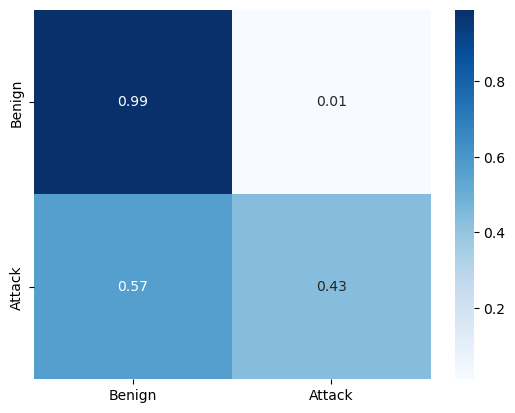

In [13]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])

In [15]:
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

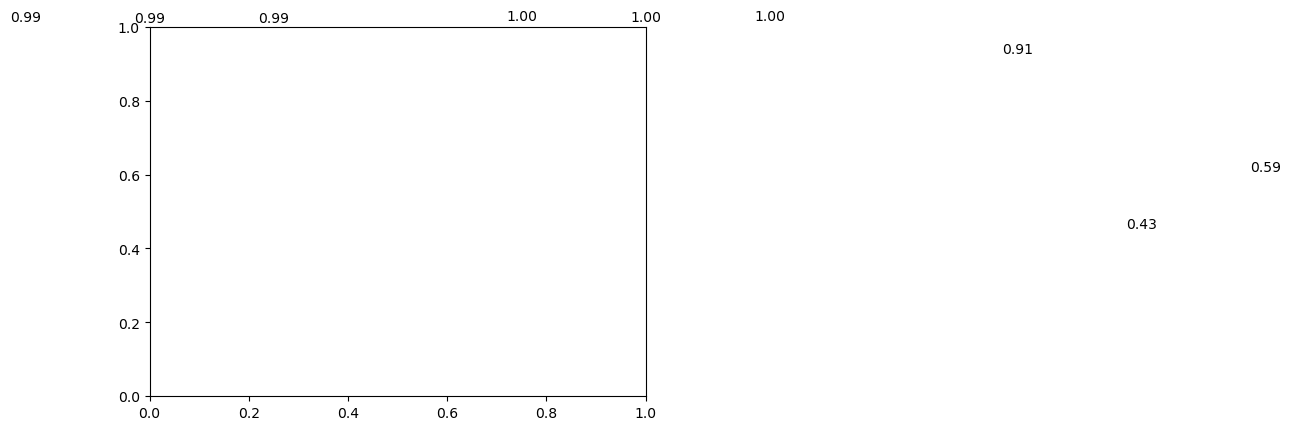

In [17]:
for i, v in enumerate(metrics['Precision']):
    plt.text(i - bar_width, v + 0.02, f'{v:.2f}', ha='center')
for i, v in enumerate(metrics['Recall']):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
for i, v in enumerate(metrics['F1 Score']):
    plt.text(i + bar_width, v + 0.02, f'{v:.2f}', ha='center')

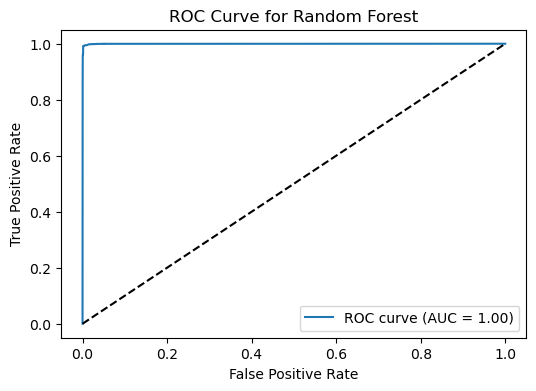

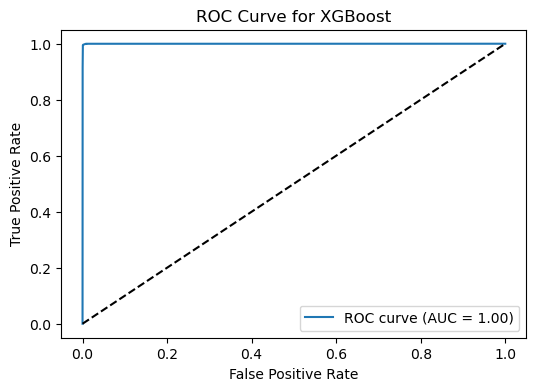

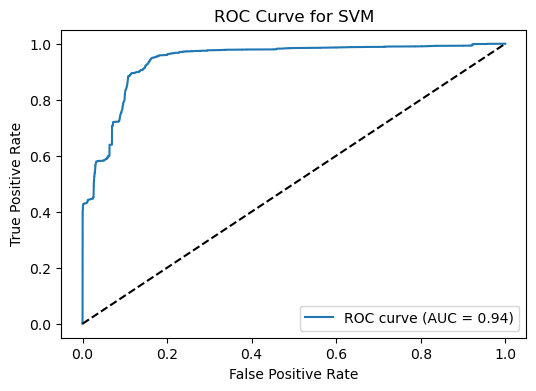

In [19]:
from sklearn.metrics import roc_curve, auc
for name, model in models.items():
    y_score = model.decision_function(X_test) if hasattr(model, 'decision_function') else model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc='lower right')
    plt.savefig(f'roc_curve_{name.lower().replace(" ", "_")}.png')
    plt.show()